In [ ]:
!pip install Prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# 라이브러리 임포트
import os
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch import autograd
from torch.utils import data
from torch.optim import Adam
from google.colab import drive
import datetime as dt
from datetime import timedelta
import seaborn as sns
from prophet import Prophet


from plotly.offline import init_notebook_mode, iplot #plotly offline mode 
init_notebook_mode(connected = True)
import plotly.graph_objs as go #plotly graphical object

import matplotlib.pyplot as plt
DATASET_PATH = os.path.join('/content/gdrive/MyDrive/글창사 traffic/data')
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# 난수 생성기가 항상 일정한 값을 출력하게 하기 위해 seed 고정
random_seed = 2021
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
np.random.seed(random_seed)

## EDA

In [ ]:
train=pd.read_csv(os.path.join(DATASET_PATH, 'train.csv'))
train

날짜  시간      10     100    101    120    121   140     150   160  \
0     20200101   0   83247   19128   2611   5161   1588   892   32263  1636   
1     20200101   1   89309   19027   3337   5502   1650  1043   35609  1644   
2     20200101   2   66611   14710   2970   4631   1044   921   26821  1104   
3     20200101   3   53290   13753   2270   4242   1021   790   21322   909   
4     20200101   4   52095   17615   2406   3689   1840   922   22711  1354   
...        ...  ..     ...     ...    ...    ...    ...   ...     ...   ...   
3274  20200517  19  311727  101285  10085  30637  10060  8749  148935  6801   
3275  20200517  20  305354   91426   8607  26021   8095  7198  136503  6147   
3276  20200517  21  306008   75113   6325  19933   5711  4494  129412  5134   
3277  20200517  22  237447   49498   4209  12145   3891  2718   96698  3526   
3278  20200517  23  150312   27410   2350   6406   1803  1614   55788  1849   

      ...  1020   1040   1100   1200  1510   2510  3000   4510   5510   6000  
0     ...  1311   3482  11299   7072  1176   3810   748   3920   2133   3799  
1     ...  1162   3849  13180   8771  1283   3763   782   3483   2057   4010  
2     ...   768   2299   7986   5426  1536   3229   491   2634   1526   3388  
3     ...   632   1716   5703   3156  1104   2882   431   2488   1268   3686  
4     ...   875   2421   5816   2933  1206   2433   499   2952   1927   5608  
...   ...   ...    ...    ...    ...   ...    ...   ...    ...    ...    ...  
3274  ...  6726  15431  25597  14292  9300  22238  3786  16936  10729  20194  
3275  ...  5501  15378  24661  14747  8239  20604  3203  15018   9767  17962  
3276  ...  4216  12558  22781  14081  6392  17937  2447  12403   7825  14031  
3277  ...  2578   8870  16640  11066  4427  11955  1495   7507   5387   8889  
3278  ...  1377   5021  10058   7139  2250   6844   735   4116   3046   4606  

[3279 rows x 37 columns]

In [ ]:
def datesetting(train): 
    train['날짜']=train['날짜'].astype(str)
    train['시간']=train['시간'].astype(str)
    train['date']=train['날짜']+train['시간']

    for i in range (0,len(train['날짜'])):
      a= train['날짜'][i]
      train['날짜'][i] =dt.datetime.strptime(a, '%Y%m%d')

    for i in range(0,len(train['시간'])):
      b= train['시간'][i]
      train['시간'][i]=dt.datetime.strptime(b, '%H')

    for i in range(0,len(train['날짜'])):
      train['date'][i]=train['날짜'][i]+timedelta(hours=train['시간'][i].hour)
    

In [ ]:
datesetting(train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
val=pd.read_csv(os.path.join(DATASET_PATH, 'validate.csv'))
datesetting(val)
val

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



날짜                   시간      10    100    101    120  \
0    2020-05-11 00:00:00  1900-01-01 00:00:00   77968  14429   1233   4021   
1    2020-05-11 00:00:00  1900-01-01 01:00:00   48679   9136    823   2618   
2    2020-05-11 00:00:00  1900-01-01 02:00:00   33773   8199    578   2188   
3    2020-05-11 00:00:00  1900-01-01 03:00:00   41511   9986    726   2817   
4    2020-05-11 00:00:00  1900-01-01 04:00:00   78680  19509   1463   4720   
..                   ...                  ...     ...    ...    ...    ...   
331  2020-05-24 00:00:00  1900-01-01 19:00:00  314226  98345  10625  28618   
332  2020-05-24 00:00:00  1900-01-01 20:00:00  300001  87871   8226  22706   
333  2020-05-24 00:00:00  1900-01-01 21:00:00  304150  71126   6002  18317   
334  2020-05-24 00:00:00  1900-01-01 22:00:00  236751  44947   3575  11455   
335  2020-05-24 00:00:00  1900-01-01 23:00:00  143609  26137   2242   6166   

      121   140     150   160  ...   1040   1100   1200  1510   2510  3000  \
0     981   881   28672  1064  ...   2604   5239   4168  1155   3596   337   
1     654   572   17722   672  ...   1870   3359   2558  1002   2157   257   
2     392   502   14464   579  ...   1499   2646   2022   876   1959   232   
3     555   646   17793   650  ...   1730   3398   1967   912   2462   281   
4     825  1088   35125   997  ...   2958   7369   4120  1569   4568   577   
..    ...   ...     ...   ...  ...    ...    ...    ...   ...    ...   ...   
331  8316  6684  141675  6619  ...  16118  23304  14082  8447  21694  2180   
332  6981  5743  142933  6295  ...  15297  21919  14526  7332  19732  1990   
333  4939  3779  133110  4781  ...  12685  21135  14403  5443  16967  1359   
334  3135  2536   98582  3267  ...   8093  14427  10914  3861  11397   859   
335  1609  1391   54633  1899  ...   4686   8732   6986  2161   6487   410   

      4510   5510   6000                 date  
0     2262   1608   2337  2020-05-11 00:00:00  
1     1425   1018   1810  2020-05-11 01:00:00  
2     1155    927   1530  2020-05-11 02:00:00  
3     1477    959   1882  2020-05-11 03:00:00  
4     3155   1871   3656  2020-05-11 04:00:00  
..     ...    ...    ...                  ...  
331  15746  10903  21014  2020-05-24 19:00:00  
332  14096  10028  17787  2020-05-24 20:00:00  
333  11670   7963  14041  2020-05-24 21:00:00  
334   7270   5194   8230  2020-05-24 22:00:00  
335   3963   2686   4690  2020-05-24 23:00:00  

[336 rows x 38 columns]

In [ ]:
test=pd.read_csv(os.path.join(DATASET_PATH, 'test.csv'))
datesetting(test)
test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



날짜                   시간     10    100   101   120   121  \
0    2020-05-18 00:00:00  1900-01-01 00:00:00  82065  15172  1500  3294  1086   
1    2020-05-18 00:00:00  1900-01-01 01:00:00  51248   9840   813  2356   696   
2    2020-05-18 00:00:00  1900-01-01 02:00:00  39026   7894   760  2413   408   
3    2020-05-18 00:00:00  1900-01-01 03:00:00  40993  10137   780  2701   420   
4    2020-05-18 00:00:00  1900-01-01 04:00:00  77863  19603  1276  5019   968   
..                   ...                  ...    ...    ...   ...   ...   ...   
331  2020-05-31 00:00:00  1900-01-01 19:00:00   -999   -999  -999  -999  -999   
332  2020-05-31 00:00:00  1900-01-01 20:00:00   -999   -999  -999  -999  -999   
333  2020-05-31 00:00:00  1900-01-01 21:00:00   -999   -999  -999  -999  -999   
334  2020-05-31 00:00:00  1900-01-01 22:00:00   -999   -999  -999  -999  -999   
335  2020-05-31 00:00:00  1900-01-01 23:00:00   -999   -999  -999  -999  -999   

      140    150   160  ...  1040  1100  1200  1510  2510  3000  4510  5510  \
0     962  28931  1103  ...  2790  5147  4331  1329  3665   404  2242  1619   
1     546  17888   720  ...  1864  3269  2561   921  2081   272  1390  1003   
2     549  13357   498  ...  1313  2765  1931   920  1764   228  1136   922   
3     741  15544   532  ...  1766  3320  2060   892  2447   337  1495   975   
4    1160  32101   968  ...  2914  6986  3911  1368  4380   513  2940  1758   
..    ...    ...   ...  ...   ...   ...   ...   ...   ...   ...   ...   ...   
331  -999   -999  -999  ...  -999  -999  -999  -999  -999  -999  -999  -999   
332  -999   -999  -999  ...  -999  -999  -999  -999  -999  -999  -999  -999   
333  -999   -999  -999  ...  -999  -999  -999  -999  -999  -999  -999  -999   
334  -999   -999  -999  ...  -999  -999  -999  -999  -999  -999  -999  -999   
335  -999   -999  -999  ...  -999  -999  -999  -999  -999  -999  -999  -999   

     6000                 date  
0    2314  2020-05-18 00:00:00  
1    1766  2020-05-18 01:00:00  
2    1309  2020-05-18 02:00:00  
3    1912  2020-05-18 03:00:00  
4    3629  2020-05-18 04:00:00  
..    ...                  ...  
331  -999  2020-05-31 19:00:00  
332  -999  2020-05-31 20:00:00  
333  -999  2020-05-31 21:00:00  
334  -999  2020-05-31 22:00:00  
335  -999  2020-05-31 23:00:00  

[336 rows x 38 columns]

In [ ]:
#hour/month/day data를 생성하여 추가
# train=train.drop(['날짜','시간'],axis=1)
train=train.set_index('date')
train['hour']=train.index.hour
train['month']=train.index.month
train['day']=train.index.day
# val=val.drop(['날짜','시간'],axis=1)
val=val.set_index('date')
val['hour']=val.index.hour
val['month']=val.index.month
val['day']=val.index.day
# test=test.drop(['날짜','시간'],axis=1)
test=test.set_index('date')
test['hour']=test.index.hour
test['month']=test.index.month
test['day']=test.index.day
# EDA를 위해 train과 val 합쳐서 df로 분석
df=pd.concat([train,val])

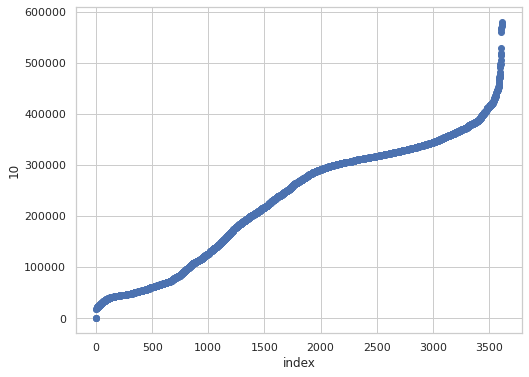

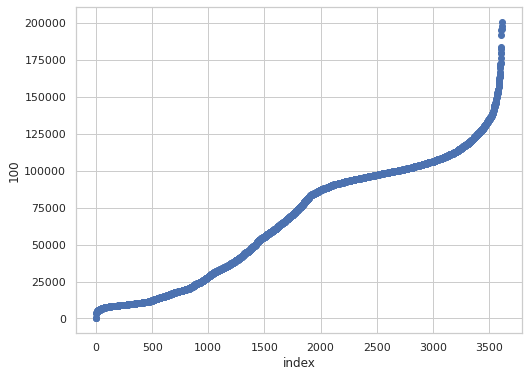

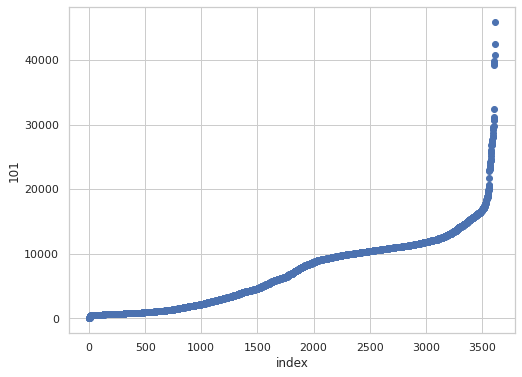

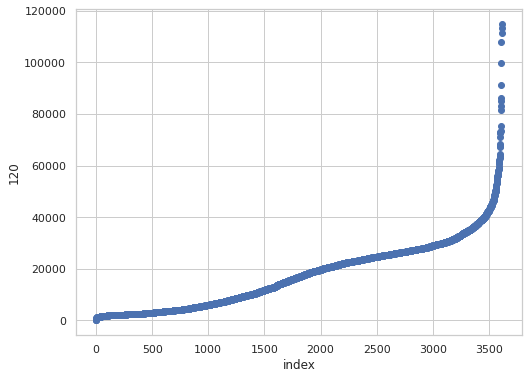

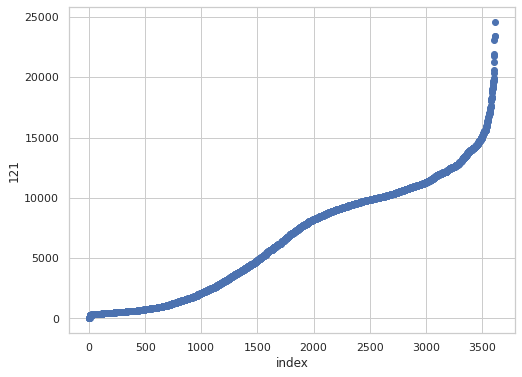

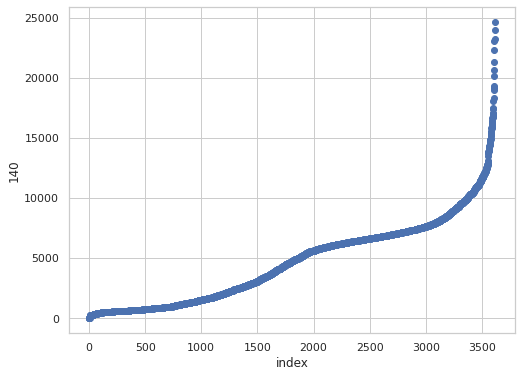

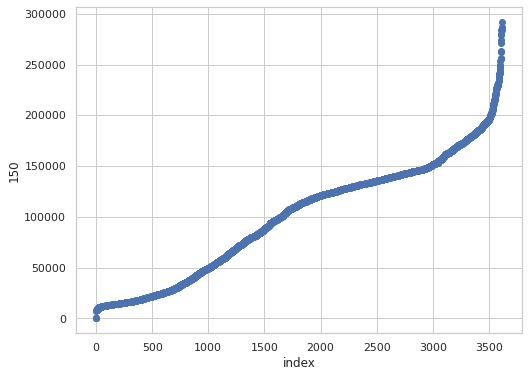

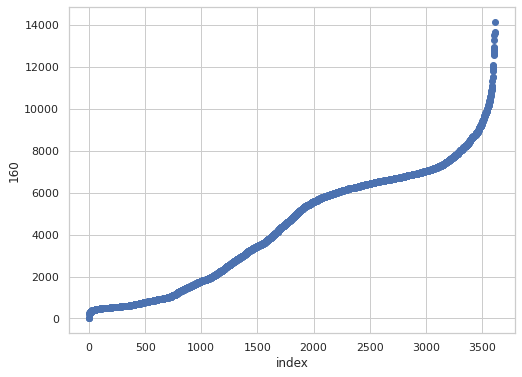

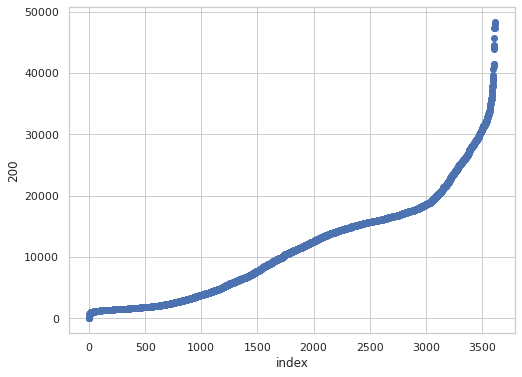

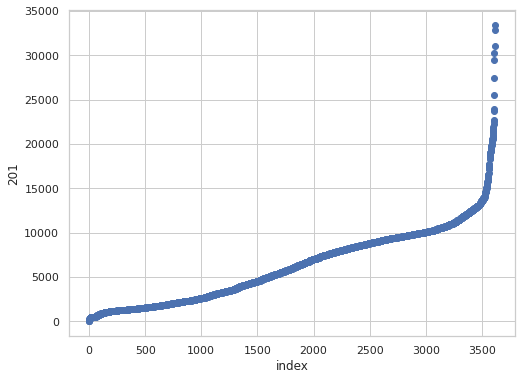

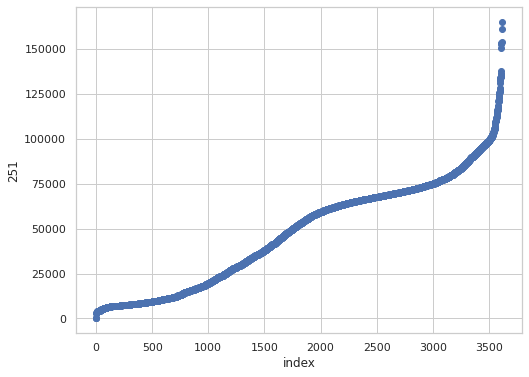

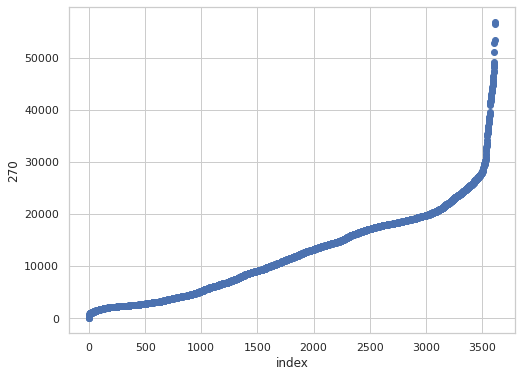

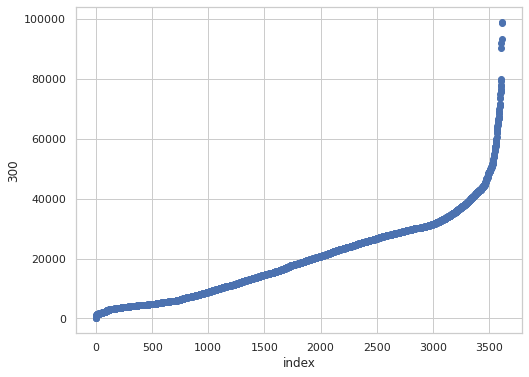

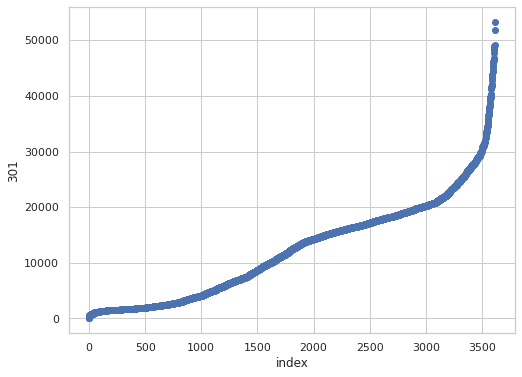

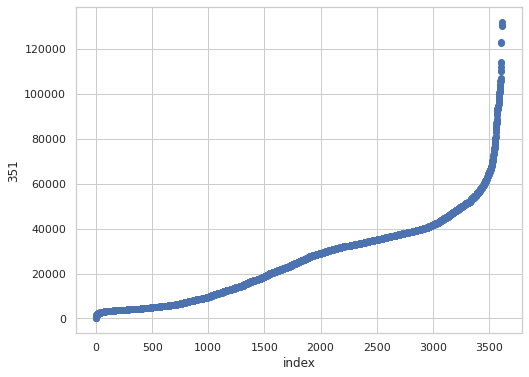

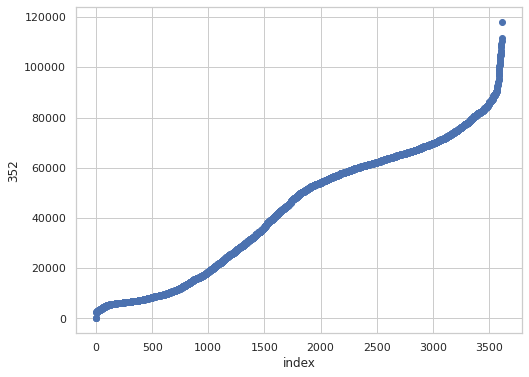

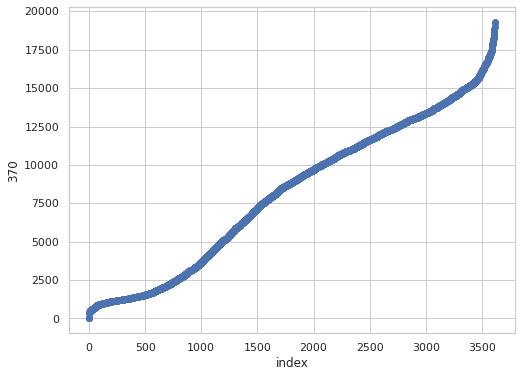

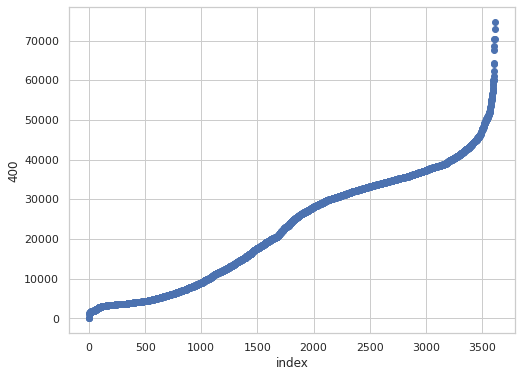

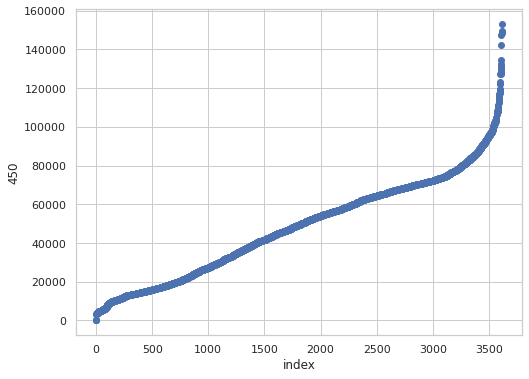

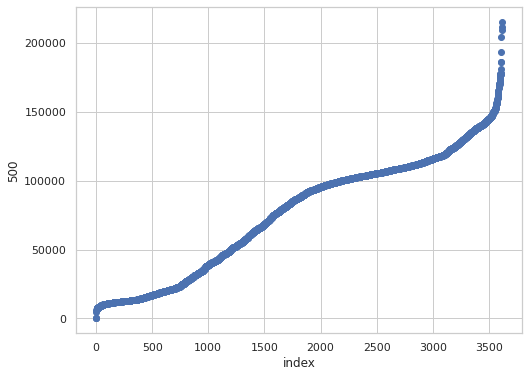

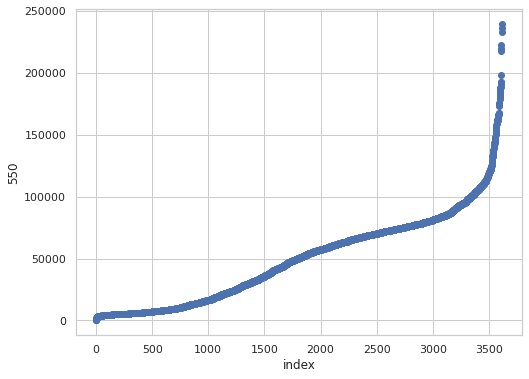

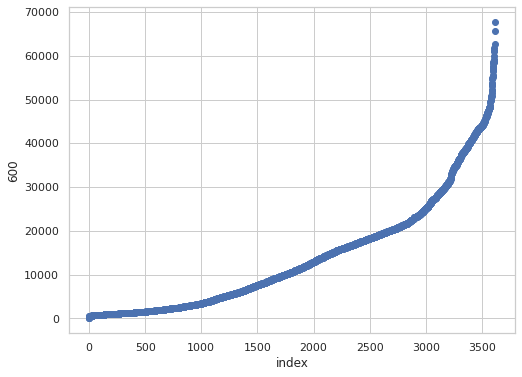

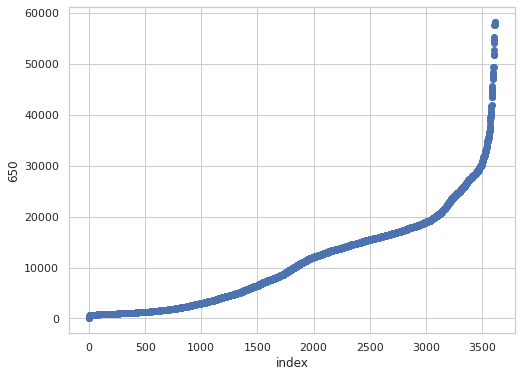

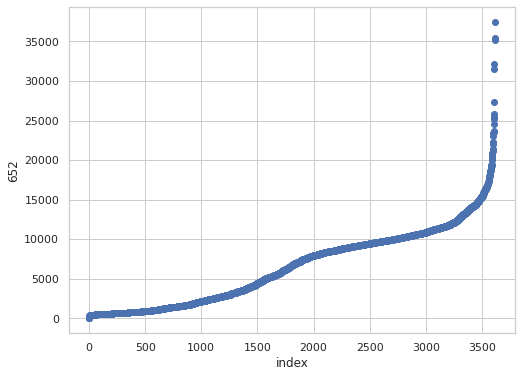

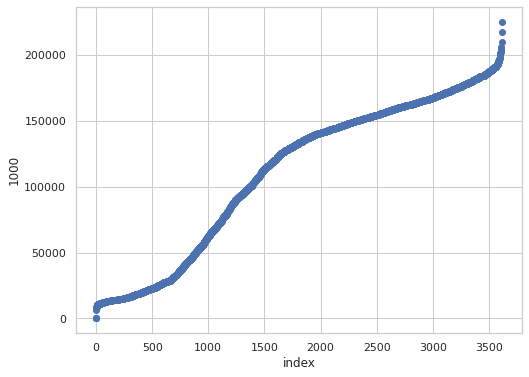

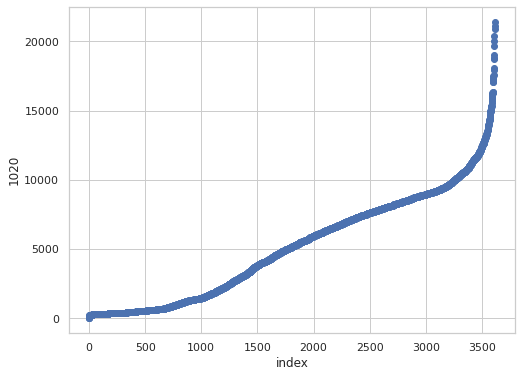

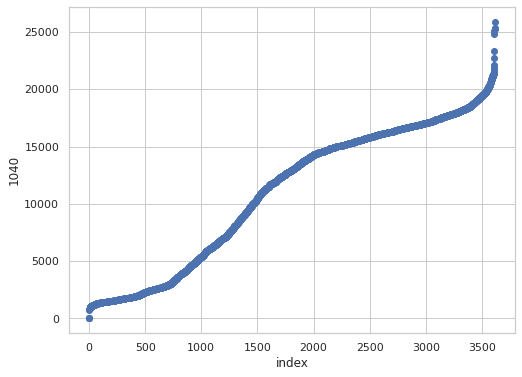

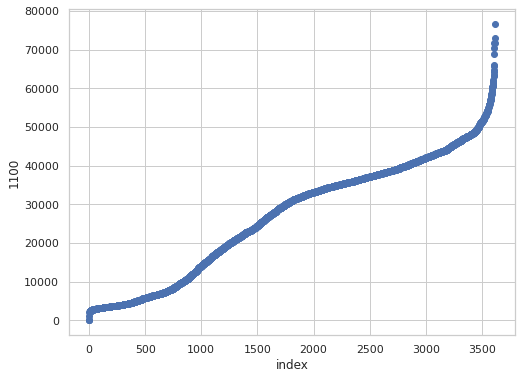

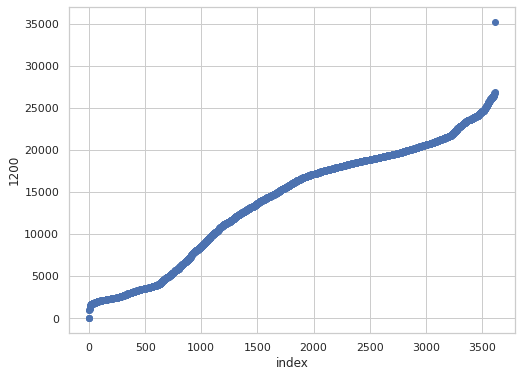

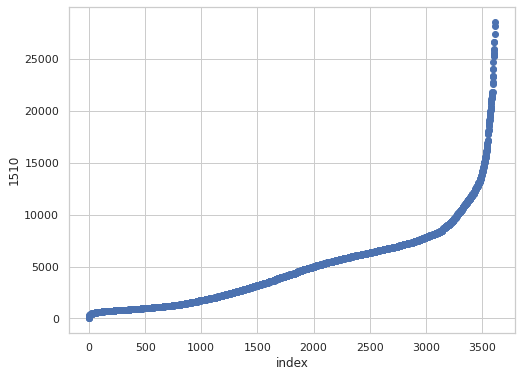

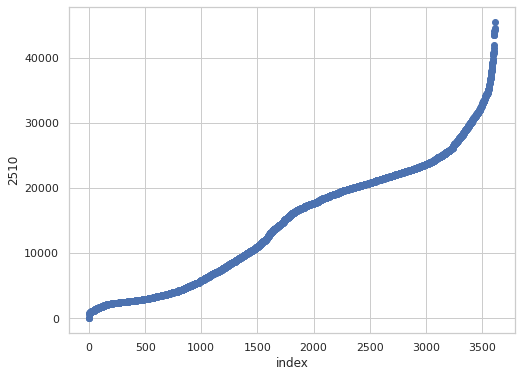

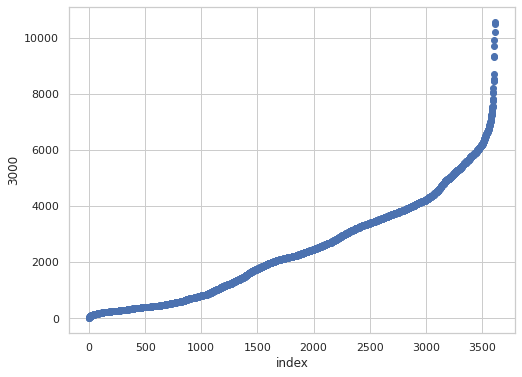

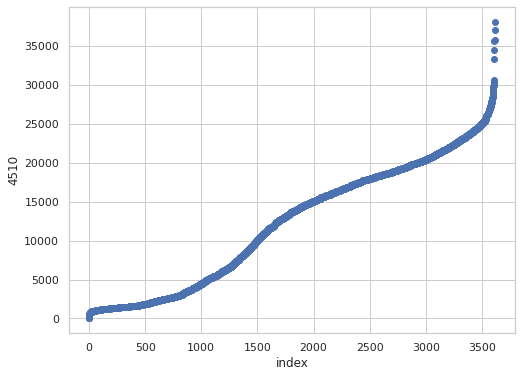

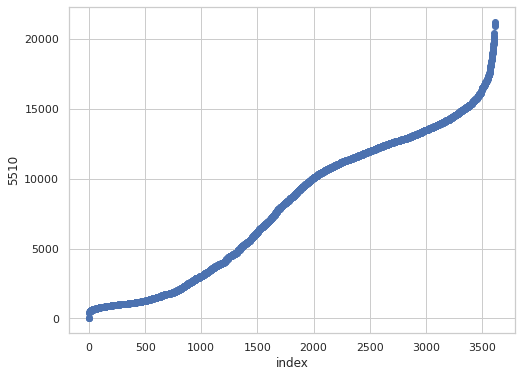

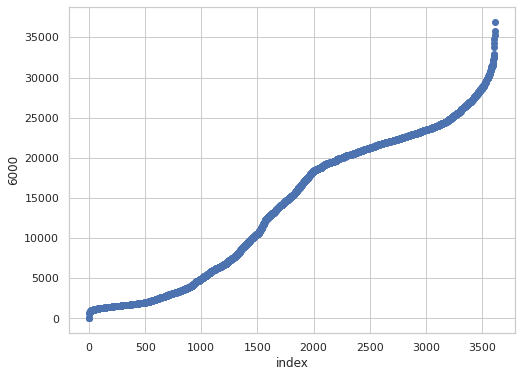

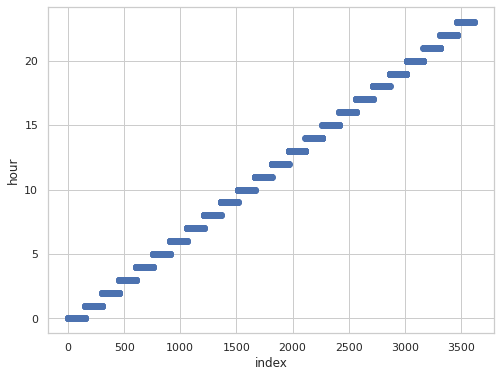

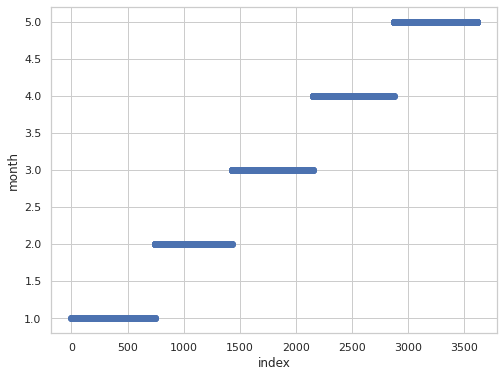

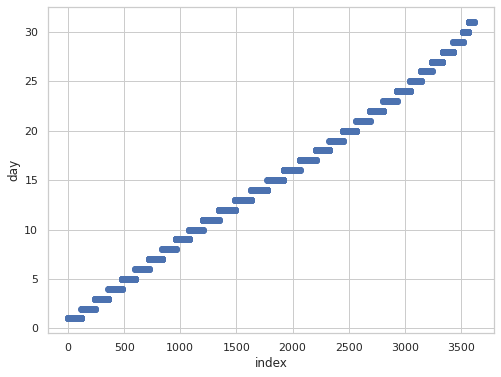

In [ ]:
# Data의 값의 분포를 파악하기 위해 크기순으로 나열하는 그래프
for i in range(2,len(df.columns)):
  sns.set(rc={'figure.figsize':(14.7,6)})
  sns.set_style("whitegrid")
  plt.figure(figsize=(8,6))
  plt.scatter(range(df.shape[0]), np.sort(df.iloc[:,i].values))
  plt.xlabel('index', fontsize=12)
  plt.ylabel(df.iloc[:,i].name, fontsize=12)
  plt.show()

- 값들이 편중되지 않고, 우상향 하며 커지는 것으로 보아 특정 구간 내에서 반복되는 주기성을 가진다. 

- '1000','1510', '3000'을 제외하고는 (값의 차이만 존재) 비슷하다.

In [ ]:
# 요약 통계량 표시함에 있어서 간략하게 보기 위해 몇가지 정보를 제외함.
a=pd.DataFrame(df.describe())
a=a.reset_index()

b=a.drop([0,2,4,6],axis=0)

b = b.set_index('index')
print(b)

                 10            100           101            120           121  \
index                                                                           
mean   232017.30816   67148.673029   7175.630152   17529.489073   6662.991701   
min         0.00000       0.000000      0.000000       0.000000      0.000000   
50%    268088.00000   74773.000000   6951.000000   16895.000000   7050.000000   
max    580098.00000  200808.000000  45869.000000  114833.000000  24596.000000   

                140           150           160           200          201  \
index                                                                        
mean    4717.493223   99619.37621   4412.565698  11499.318119   6279.57455   
min        0.000000       0.00000      0.000000      0.000000      0.00000   
50%     4766.000000  112223.00000   4781.000000  10909.000000   5973.00000   
max    24639.000000  292004.00000  14163.000000  48349.000000  33416.00000   

       ...         1200          1510       

In [ ]:
#max값의 최대 최소(hour/month/day제외)
print(b.iloc[2,:-3].max())
print(b.iloc[2,:-3].min())

580098.0
10581.0


- 전체 데이터 중 최댓값은 580098 이다.
- 각 컬럼의 최댓값을 표기한 값중 가장 작은 값은 10581이다. 

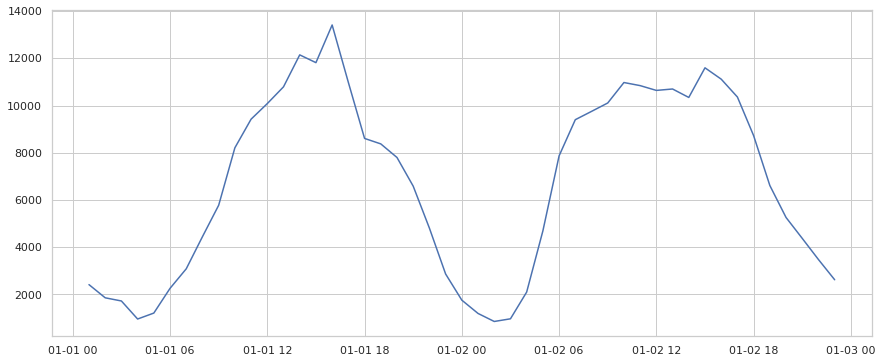

In [ ]:
plt.plot(df['370'][1:48])

- 일별로 그래프를 그려 본 결과 주기성을 포착하여 decomposition 시도

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc4r_gwd5/efns1wuh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc4r_gwd5/n_v5hfjf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63438', 'data', 'file=/tmp/tmpc4r_gwd5/efns1wuh.json', 'init=/tmp/tmpc4r_gwd5/n_v5hfjf.json', 'output', 'file=/tmp/tmpomocqc8z/prophet_model-20220725061742.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:17:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:17:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


                                                      
-----------------------------150 is done----------------------------------------


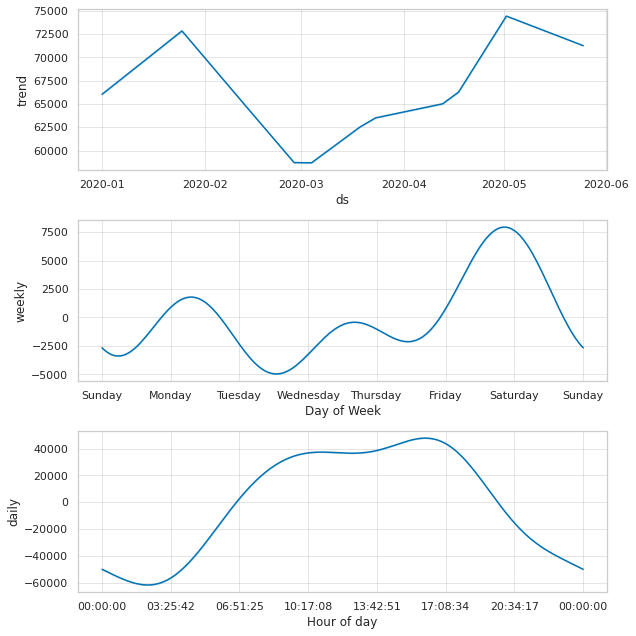

In [ ]:
# prophetm에 columns 몇번째인지 넣으면 decomposition graph가 나오는 함수
def prophetm(order):
    x = df.iloc[:,order].reset_index().rename(columns = {'date':'ds',df.iloc[:,order].reset_index().columns[1]:'y'})
    m = Prophet()
    forecast = m.fit(x).predict(x)
    fig = m.plot_components(forecast)
    print('                                                      ')
    print(f'-----------------------------{df.iloc[:,i].reset_index().columns[1]} is done----------------------------------------')
prophetm(3)
#Prophet decomposition을 통해 daily, weekly, trend 그래프 그리는 함수 생성

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc4r_gwd5/a6lyxcnu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc4r_gwd5/w9o2lkzl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96860', 'data', 'file=/tmp/tmpc4r_gwd5/a6lyxcnu.json', 'init=/tmp/tmpc4r_gwd5/w9o2lkzl.json', 'output', 'file=/tmp/tmpcgnq633r/prophet_model-20220725065353.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:53:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:53:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


                                                      
-----------------------------150 is done----------------------------------------


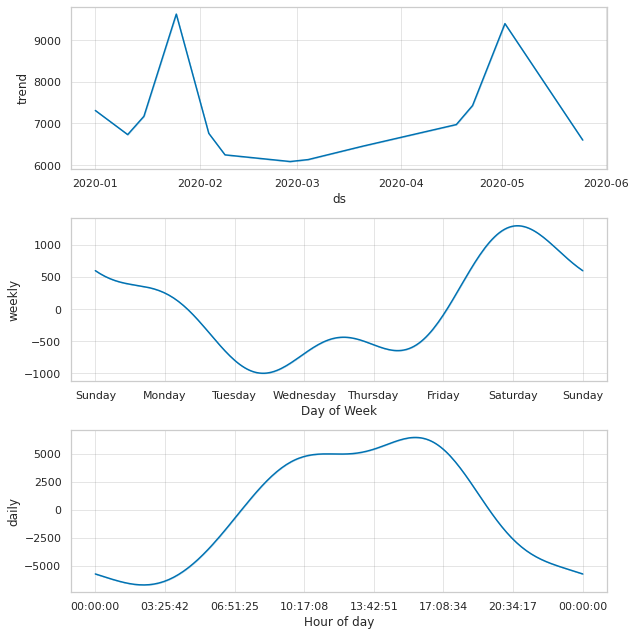

In [ ]:
prophetm(4)

- 그래프는 진동하는 형태로 그려지지만 prophet decomposition 에서는 trend가 진동하는 형태로 그려지지 않는다.
=> 다른 구역도 확인이 필요.

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc4r_gwd5/9hmkxqbk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc4r_gwd5/6s2avh4w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33847', 'data', 'file=/tmp/tmpc4r_gwd5/9hmkxqbk.json', 'init=/tmp/tmpc4r_gwd5/6s2avh4w.json', 'output', 'file=/tmp/tmppyy3p48a/prophet_model-20220725065742.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:57:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:57:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


                                                      
-----------------------------150 is done----------------------------------------


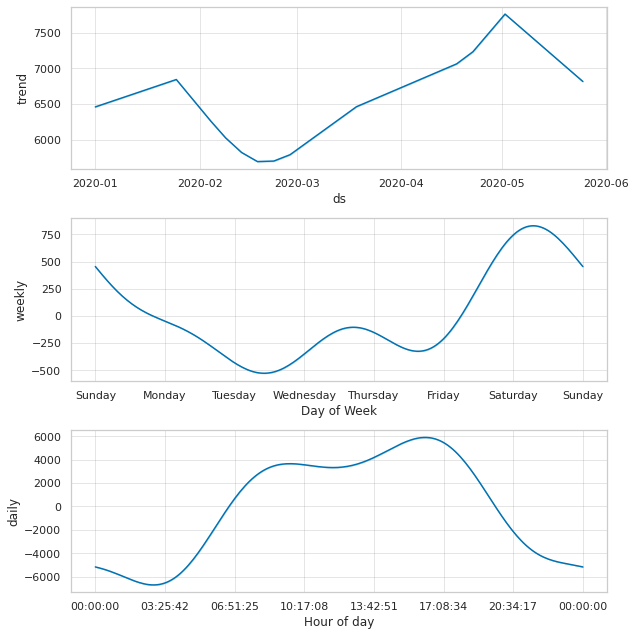

In [ ]:
prophetm(6)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc4r_gwd5/dqgn96n2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc4r_gwd5/jgaixysx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18104', 'data', 'file=/tmp/tmpc4r_gwd5/dqgn96n2.json', 'init=/tmp/tmpc4r_gwd5/jgaixysx.json', 'output', 'file=/tmp/tmpj8yvhu39/prophet_model-20220725065813.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:58:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:58:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


                                                      
-----------------------------150 is done----------------------------------------


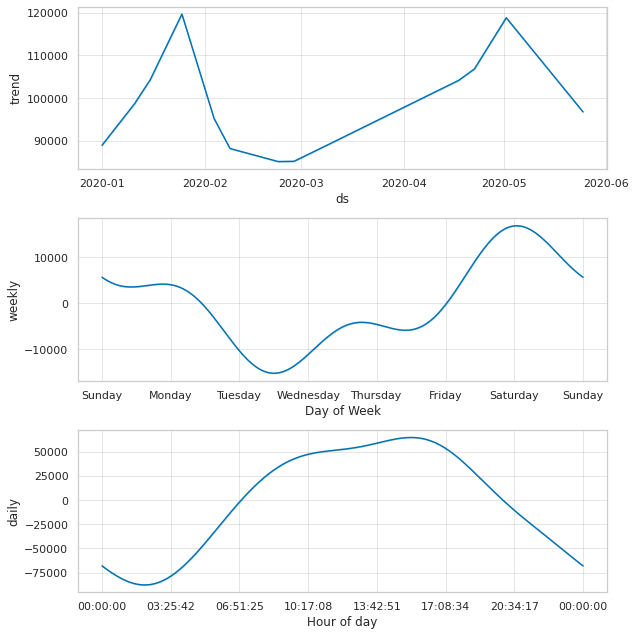

In [ ]:
prophetm(8)

- trend의 모양자체는 전체적으로 비슷하다.(절댓값만 다르다.)
- 나머지 주기성 그래프 또한 비슷한 모양 (Hour of day -> 코끼리를 삼킨뱀)


In [ ]:
for i in range(2,len(train.columns)):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train.index, y=train.iloc[:,i], name = train.iloc[:,i].name, mode='lines'))
    fig.update_layout(title=train.iloc[:,i].name, titlefont=dict(size=25))
    # fig.add_trace(go.Scatter(x=train.index, y=train.iloc[:,1],name=train.iloc[:,1].name, mode='lines'))  
    # fig.update_layout(legend=dict(y=0.8, traceorder='reversed', font_size=16))
    # fig.write_html('file.html')
    fig.show(renderer="colab") 
    print(f'-------------------------------{train.iloc[:,i].name} is done----------------------------------')

-------------------------------10 is done----------------------------------


-------------------------------100 is done----------------------------------


-------------------------------101 is done----------------------------------


-------------------------------120 is done----------------------------------


-------------------------------121 is done----------------------------------


-------------------------------140 is done----------------------------------


-------------------------------150 is done----------------------------------


-------------------------------160 is done----------------------------------


-------------------------------200 is done----------------------------------


-------------------------------201 is done----------------------------------


-------------------------------251 is done----------------------------------


-------------------------------270 is done----------------------------------


-------------------------------300 is done----------------------------------


-------------------------------301 is done----------------------------------


-------------------------------351 is done----------------------------------


-------------------------------352 is done----------------------------------


-------------------------------370 is done----------------------------------


-------------------------------400 is done----------------------------------


-------------------------------450 is done----------------------------------


-------------------------------500 is done----------------------------------


-------------------------------550 is done----------------------------------


-------------------------------600 is done----------------------------------


-------------------------------650 is done----------------------------------


-------------------------------652 is done----------------------------------


-------------------------------1000 is done----------------------------------


-------------------------------1020 is done----------------------------------


-------------------------------1040 is done----------------------------------


-------------------------------1100 is done----------------------------------


-------------------------------1200 is done----------------------------------


-------------------------------1510 is done----------------------------------


-------------------------------2510 is done----------------------------------


-------------------------------3000 is done----------------------------------


-------------------------------4510 is done----------------------------------


-------------------------------5510 is done----------------------------------


-------------------------------6000 is done----------------------------------


-------------------------------hour is done----------------------------------


-------------------------------month is done----------------------------------


-------------------------------day is done----------------------------------


- 1월 말 기준 상승하면서 진동  
- 5월 초 기준 상승하면서 진동
- 두번의 상승을 비교한다면 1월 말의 증가폭이 더 크다. 

**- Prophet decomposition trend정보 신뢰도 상승**

정리 링크 -https://evening-satin-e96.notion.site/Graph-plotly-4bafbae26b924d999b8b03f9a055949f

## Dataloader
* 한 칼럼에 대한 7일(168행) 데이터를 input_data, 뒤따르는 7일 데이터를 output_data로 반환합니다.
* 도로별 차이를 두지 않고 모든 도로를 동일한 타입의 데이터로 취급합니다.
* 모든 csv 파일의 마지막 168행은 예측해야하는 값이므로 input으로 들어가지 않습니다.

In [ ]:
class CustomDataset(data.Dataset):      # torch.utils.data.Dataset 클래스의 상속 클래스 CustomDataset 클래스 생성. 상속 클래스 생성시 __init__, __getitem__, __len__함수는 기본적으로 정의해줘야 함.
    
    def __init__(self, root, seq_len, batch_size=64, phase='train'):      # 데이터 로드 단계에 사용될 여러 변수들을 'self.변수명'의 형태로 지정해두는 함수
        
        self.root = root      # CustomDataset 객체 생성 시 데이터 경로 앞부분(공통 부분)을 root로 입력받아 저장
        self.phase = phase      # CustomDataset 객체 생성 시 데이터 경로 뒷부분(train/validate/test)을 phase로 입력받아 저장
        self.label_path = os.path.join(self.root, self.phase + '.csv')      # 데이터 전체 경로 생성
        df = pd.read_csv(self.label_path)      # 생성한 데이터 전체 경로로부터 데이터 로드
        
        self.seq_len = seq_len * 24      # 일 단위 기간을 입력 받은 후 시간 단위 기간으로 변환하여 저장
        self.batch_size = batch_size
        self.labels = {}
        #self구조의 함수를 설정해서 자기 함수를 초기화 해서 다시 사용할 수 있도록 init처리
        
        timestamps = [(i, j) for (i, j) in zip(list(df['날짜']), list(df['시간']))]      # 날짜와 시간 정보가 튜플로 들어 있는 리스트 생성
        categories = df.columns.values.tolist()[2:]      # 도로명 column list 생성

        input_data = []
        output_data = []

        for t in range(len(timestamps)):
            temp_input_data = []
            temp_output_data = []
            for col in categories:
                road = df[col].tolist()
                inp = [float(i) for i in road[t:t+self.seq_len]]      # input 데이터 시계열 구간 설정
                outp = [float(j) for j in road[t+self.seq_len:t+2*self.seq_len]]      # output 데이터 시계열 구간 설정
                temp_input_data.append(inp) 
                temp_output_data.append(outp)
            input_data.append(temp_input_data)
            output_data.append(temp_output_data)
            
# input_data : [[첫번째 input 기간 동안의 첫번째 도로의 통행량 list, ..., 첫번째 input 기간 동안의 35번째 도로의 통행량 list], ...,
#               [마지막 input 기간 동안의 첫번째 도로의 통행량 list, ..., 마지막 input 기간 동안의 35번째 도로의 통행량 list]]
# output_data : [[첫번째 output 기간 동안의 첫번째 도로의 통행량 list, ..., 첫번째 output 기간 동안의 35번째 도로의 통행량 list], ...,
#                [마지막 output 기간 동안의 첫번째 도로의 통행량 list, ..., 마지막 output 기간 동안의 35번째 도로의 통행량 list]]
        
        self.labels['timestamp'] = timestamps
        self.labels['category'] = categories
        self.labels['input'] = input_data
        self.labels['output'] = output_data

    def __getitem__(self, index):      # index를 가지고 데이터를 하나씩 불러올 수 있게 하는 함수
    
#         데이터 내 index가 부여되는 형태

#                 | road_1    road_2    ...  road_35
#                -------------------------------------
#         time_1  | index_0   index_1   ...  index_34
#         time_2  | index_35  index_36  ...  index_69

        row = index // 35      # index를 35(도로수)로 나눈 몫  ex) 71//35 -> 2
        col = index % 35      # index를 35(도로수)로 나눈 나머지  ex) 71%35 -> 1

        timestamp = self.labels['timestamp'][row]      # (날짜, 시간) 튜플이 들어있는 list에서 row번째 시점에 해당하는 튜플 - timestamp
        category = self.labels['category'][col]      # 도로명 column list에서 col번째 도로에 해당하는 element - column
        
        input_data = torch.tensor(self.labels['input'][row][col])      # input_data list에서, row번째 시점의 col번째 도로 교통량 정보
        norm = input_data[-1]
        input_data = input_data / input_data[-1]
        if self.phase != 'test':
            output_data = torch.tensor(self.labels['output'][row][col]) / norm
        else:
            output_data = []

        return timestamp, category, (input_data, output_data, norm)

    def __len__(self):      # getitem 함수를 통해 데이터를 불러오려면,전체 index 길이를 알아야 한다.
        return (len(self.labels['timestamp']) - (self.seq_len * 2) + 1) * 35      # 특정 시점이 아닌 특정 기간을 하나의 data 단위로 설정하면, 전체 샘플 수는 감소함을 반영 


def data_loader(root, phase='train', batch_size=64, seq_len=7, drop_last=False):
    if phase == 'train':
        shuffle = True
        ##shuffle이 False?
    else:
        shuffle = False

    dataset = CustomDataset(root, seq_len, batch_size, phase)
    dataloader = data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last)

    return dataloader

## Model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class LSTMNet(nn.Module):      # torch.nn.Module 클래스의 상속 class LSTMNet class 생성. 상속 클래스 생성시 __init__, forward 함수는 기본적으로 정의해줘야 함.
    def __init__(self,
                 input_size=168,      # input 길이는 168시간(7일 X 24시간)
                 hidden_size=1024,
                 output_size=168,      # output 길이는 168시간(7일 X 24시간)
                 batch_size=64,
                 num_layers=3,
                 dropout=0,
                 batch_first=False):      # batch_first(default=False) : 배치 차원을 첫번째 차원으로 하여 데이터를 불러올 것인지 여부 RNN예시에서는 shuffle을 False로 바꾸고 batch_first를 True로 바꿈.

        super(LSTMNet, self).__init__()

        self.hidden_size = hidden_size
        
        ##### Layer 1
        self.lstm1 = nn.LSTM(input_size,
                             hidden_size,
                             dropout=0.2,
                             num_layers=num_layers)

        ##### Layer 2
        self.lstm2 = nn.LSTM(hidden_size, 
                             hidden_size,
                             dropout=0.2,
                             num_layers=num_layers)

        ##### Finalize
        self.linear = nn.Linear(hidden_size, 
                                output_size)
        
        self.activation = nn.ReLU()

        
    def forward(self, x):      # forward 함수를 직접 호출할 일은 없음. model = LSTMNet() 객체를 생성한 다음, 
                                           # predictions, (h2, c_2) = model(input_data, h_in, c_in) 형태로 return을 받으면 됨


        lstm_out, (h_1, c_1) = self.lstm1(x)
        lstm_out = self.activation(lstm_out)

        # Layer2
        lstm_out, (h_2, c_2) = self.lstm2(lstm_out, (h_1, c_1))
        lstm_out = self.activation(lstm_out)

        # Final
        predictions = self.linear(lstm_out)
        
        return predictions

In [ ]:
# 결과 파일과 모델 가중치 파일 저장을 위해 log 디렉토리 생성. 중요한 파일이 덮어씌워지지 않도록 주의
os.makedirs('log', exist_ok=True)      # log 폴더 생성, 이미 생성되었을 시 추가로 생성하지 않도록 exist_ok=True


def save_model(model_name, model, optimizer):      # 모델 가중치 파일 저장 함수
    state = {
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict()
    }
    torch.save(state, os.path.join('log', model_name + '.pth'))
    print('model saved\n')


def load_model(model_name, model, optimizer=None):      # 모델 가중치 파일 로드 함수
    state = torch.load(os.path.join(model_name))
    model.load_state_dict(state['model'])
    if optimizer is not None:
        optimizer.load_state_dict(state['optimizer'])
    print('model loaded')

## Hyperparameters

In [ ]:
dtype = torch.float
num_epochs = 5
base_lr = 0.01
seq_len = 7

input_size = seq_len * 24
hidden_size = 1024
output_size = input_size
batch_size = 64
num_layers = 6

## Training Setting

In [ ]:
# model
model = LSTMNet(input_size=input_size,
                hidden_size=hidden_size,
                output_size=output_size,
                batch_size=batch_size,
                num_layers=num_layers)

model = model.to(device)

# loss function
criterion = nn.MSELoss()      # 플랫폼 상 채점은 RMSE, 즉 MSE에 root를 씌운 값이기 때문에 사실상 평가지표와 같은 Loss입니다.

# optimizer
optimizer = Adam(model.parameters(), lr=base_lr)      # optimizer로는 Adam이 가장 무난합니다. Adam을 쓰면 learning_rate를 따로 지정해주지 않아도 알아서 조정됩니다.

In [ ]:
print(model)

LSTMNet(
  (lstm1): LSTM(168, 1024, num_layers=6, dropout=0.2)
  (lstm2): LSTM(1024, 1024, num_layers=6, dropout=0.2)
  (linear): Linear(in_features=1024, out_features=168, bias=True)
  (activation): ReLU()
)


In [ ]:
# get data loader
train_dataloader = data_loader(root=DATASET_PATH,
                               phase='train',
                               batch_size=1,
                               seq_len=seq_len,
                               drop_last=True)

validate_dataloader = data_loader(root=DATASET_PATH,
                                  phase='validate',
                                  batch_size=1,
                                  seq_len=seq_len,
                                  drop_last=True)

## Train

In [ ]:
train_batch_loss = 0.0      # 400 batch마다 평균 training loss를 확인한 다음, train_batch_loss를 0으로 갱신해줄 것
train_epoch_loss = 0.0      # 1 epoch마다 평균 training loss를 확인한 다음, train_epoch_loss를 0으로 갱신해줄 것

valid_epoch_loss = 0.0      # 1 epoch마다 평균 validation loss를 확인한 다음, valid_epoch_loss를 0으로 갱신해줄 것
valid_min_epoch_loss = np.inf      # 초기 loss를 마이너스 무한대로 설정해두고, validation epoch loss가 낮아질 때마다 갱신해줄 것


for epoch in range(num_epochs):

    model.train()      # 모델을 train mode로 전환. train mode일 때만 적용되어야 하는 drop out 등이 적용될 수 있게 하기 위함 

    for iter_, sample in enumerate(train_dataloader):      # enumerate 함수를 통해 train_dataloader에서 'batch의 index'와 'batch'를 순서대로 호출

        _, _, (input_data, output_data, norm) = sample      # train_dataloader에서 불러온 sample은 [[날짜, 시간], [도로], [[input_data],[output_data]]]로 구성됨.
                                                      # 학습에는 [[input_data], [output_data]]만 사용
        
        input_data = input_data.unsqueeze(0).to(device)
        output_data = output_data.unsqueeze(0).to(device)

        pred = model(input_data)
        
        loss = criterion(pred, output_data)

        model.zero_grad()    # 파라미터 업데이트는 batch 단위로 이루어지고, 매 batch마다 gradient를 초기화해주어야 함 
        loss.backward()      # backpropagation
        optimizer.step()      # 파라미터 업데이트
        
        train_batch_loss += loss.item()
        train_epoch_loss += loss.item()

        if iter_ % 400 == 399:      # 400개의 batch마다 training Loss 출력
            print(norm)
            print('Train Epoch: {:2} | Batch: {:4} | Loss: {:1.2f}'.format(epoch, iter_+1, train_batch_loss/400))
            train_batch_loss = 0
            
    train_epoch_loss = 0.0      # training epoch마다 train_epoch_loss 새로 구해줄 것

    
    model.eval()      # 모델을 eval mode로 전환. eval mode에서 적용되면 안되는 drop out 등이 적용되지 않게 하기 위함

    with torch.no_grad():      # validation / test set에 대해서는 weight 및 bias의 update, 즉, gradient descent가 일어나지 않도록 no_grad()를 선언

        for iter_, sample in enumerate(validate_dataloader):      # enumerate 함수를 통해 validate_dataloader에서 'batch의 index'와 'batch'를 순서대로 호출

            _, _, (input_data, output_data, norm) = sample      # validate_dataloader에서 불러온 sample은 [[날짜, 시간], [도로], [[input_data],[output_data]]]로 구성됨. validation에는 [[input_data], [output_data]]만 사용

            input_data = input_data.unsqueeze(0).to(device)
            output_data = output_data.unsqueeze(0).to(device)

            pred = model(input_data)
            loss = criterion(pred, output_data)
            valid_epoch_loss += loss.item()

        print('\nValid Epoch: {:2} | Loss: {:1.2f}'.format(epoch, valid_epoch_loss/len(validate_dataloader)))

        if valid_epoch_loss < valid_min_epoch_loss:
            save_model('best', model, optimizer)
            valid_min_epoch_loss = valid_epoch_loss

        valid_epoch_loss = 0.0

tensor([778.])
Train Epoch:  0 | Batch:  400 | Loss: 21.05
tensor([335.])
Train Epoch:  0 | Batch:  800 | Loss: 18.02
tensor([1710.])
Train Epoch:  0 | Batch: 1200 | Loss: 18.96
tensor([6386.])
Train Epoch:  0 | Batch: 1600 | Loss: 17.23
tensor([1721.])
Train Epoch:  0 | Batch: 2000 | Loss: 13.83
tensor([14930.])
Train Epoch:  0 | Batch: 2400 | Loss: 23.09
tensor([32710.])
Train Epoch:  0 | Batch: 2800 | Loss: 21.63
tensor([17016.])
Train Epoch:  0 | Batch: 3200 | Loss: 16.20
tensor([512.])
Train Epoch:  0 | Batch: 3600 | Loss: 19.30
tensor([852.])
Train Epoch:  0 | Batch: 4000 | Loss: 23.92
tensor([72862.])
Train Epoch:  0 | Batch: 4400 | Loss: 17.56
tensor([38369.])
Train Epoch:  0 | Batch: 4800 | Loss: 16.87
tensor([1416.])
Train Epoch:  0 | Batch: 5200 | Loss: nan
tensor([115235.])
Train Epoch:  0 | Batch: 5600 | Loss: nan
tensor([1139.])
Train Epoch:  0 | Batch: 6000 | Loss: nan
tensor([1604.])
Train Epoch:  0 | Batch: 6400 | Loss: nan
tensor([2349.])
Train Epoch:  0 | Batch: 6800

## Inference

In [ ]:
dtype = torch.float
seq_len = 7

input_size = seq_len * 24
hidden_size = 1024
output_size = input_size
batch_size = 1
num_layers = 6

In [ ]:
test_dataloader = data_loader(root=DATASET_PATH,
                              phase='test',
                              batch_size=batch_size,
                                  seq_len=seq_len,
                                  drop_last=True)

In [ ]:
model = LSTMNet(input_size=input_size,
                hidden_size=hidden_size,
                output_size=output_size,
                batch_size=batch_size,
                num_layers=num_layers)

# model
model_name = 'log/best.pth'

load_model(model_name, model)
model = model.to(device)

In [ ]:
submission_file_path = os.path.join(DATASET_PATH, 'sample_submission.csv')
submission_table = pd.read_csv(submission_file_path)

In [ ]:
(h_in, c_in) = (torch.zeros(num_layers, 1, hidden_size, requires_grad=False).to(device),
                torch.zeros(num_layers, 1, hidden_size, requires_grad=False).to(device))

for iter_, sample in enumerate(test_dataloader):

    timestamp, category, (input_data, output_data) = sample
    input_data = input_data.unsqueeze(0).to(device)

    pred, (h_in, c_in) = model(input_data, h_in, c_in)

    for i, (t, h) in enumerate(zip(timestamp[0], timestamp[1])):
        for cat, row in zip(category, pred[0]):
            cat = f'{cat}'
            submission_table[cat] = row.tolist()

In [ ]:
submission_table.to_csv('prediction.csv', index=False)